In [1]:
from bs4 import BeautifulSoup
import urllib2 as ul
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
import numpy as np
plt.style.use('fivethirtyeight')


# Import the Data and read it into Pandas an merge the Company Sectors data with the financial 
# data based on company symbol

fin_data = pd.read_csv("https://raw.githubusercontent.com/wbconnelly/Bill_Data_Sci/master/project%20draft/fin_data.csv")
company_sectors = pd.read_csv("https://raw.githubusercontent.com/wbconnelly/Bill_Data_Sci/master/project%20draft/company_sectors.csv")
company_sectors.rename(columns={'Symbol':'company_symbol'}, inplace = True)

# Company data is the unaveraged dataset
company_data = pd.merge(fin_data, company_sectors, on = 'company_symbol')

In [2]:
# Compute the average of each column for each compnay over the five year period

company_avg = company_data.groupby('company_symbol').mean()
# reattch the sectors since they were dropped when getting averages
company_avg['company_symbol'] = company_avg.index
company_avg = pd.merge(company_avg, company_sectors, on = 'company_symbol')


In [3]:
# Explore features by observing which columns have the most missing values in each sector

#creae an empty dictionary to store the data frames with the Sector null counts
null_list = {}

# add each to  data frame to see which columns for each sector are good candidates as predictors
for sector in company_data.Sector.unique():
    null_df = pd.DataFrame(company_data[company_data.Sector == sector].isnull().sum()).reset_index()
    null_df.rename(columns = {0:'null_count', 'index':'col_title'}, inplace = True)
    null_list[sector] = null_df


In [4]:
# Delete the unused columns from the list of features
feature_cols = list(company_avg.loc[:, company_avg.dtypes == np.float64].columns)

col_list_delete = ['extraordinaryitems',
'deferredcharges',
'accountingchange',
'amended',
'audited',
'Unnamed: 0_y', 'preliminary',
'Unnamed: 0_x',
 'year',
 'quarter',
 'restated',
'company_cik', 
'usdconversionrate',
'periodlength',
'original', 'crosscalculated', 'discontinuedoperations', 
'changeininventories', 'inventoriesnet',' otherequity', 'equityearnings']


for col in col_list_delete:
    try:    
        feature_cols.remove(col)    
    except:
        pass
feature_cols.append('Sector')

In [5]:
# Create a list of sectors to iterate over
sector_list = list(company_avg.Sector.unique())

In [6]:
# impute all NaN values with the mean from it's respective sector

feature_dfs = []
for sector in sector_list:  
    x = company_avg[company_avg.Sector == sector][feature_cols]
    industry = pd.DataFrame(x.Sector, columns = ['Sector'])
    x.drop('Sector', axis = 1, inplace= True)
    x = x.fillna(x.mean())
    #x = (x - x.mean())/ np.std(x)
    #x = scaler.fit_transform(x)    
    x = x.join(industry)
    feature_dfs.append(x)
    
x = pd.concat(feature_dfs)
x.reset_index(inplace = True)

# Impute any remaining null values with the overall mean.
x = x.fillna(x.mean())

In [7]:
# Create an empty dictionary and fill it tables of the variance in each column for each sector

var_list = {}
for sector in sector_list:
    var_tbl = pd.DataFrame(x[feature_cols][x.Sector == sector].var().reset_index())
    var_tbl.rename(columns = {0:'variance', 'index':'col_title'}, inplace = True)
    var_tbl.sort('variance', ascending = False, inplace = True)
    var_tbl['total_var']= var_tbl['variance'].cumsum(skipna = True)/var_tbl.variance.sum()
    var_list[sector] = var_tbl

In [8]:
# Get dummy values for the Sectors
y_vals = pd.get_dummies(x.Sector)
x.drop('Sector', axis = 1, inplace= True)
feature_cols.remove('Sector')

In [9]:
# Center and scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

x = scaler.fit_transform(x[feature_cols])
x = pd.DataFrame(x, columns = feature_cols)


In [28]:
# Create empty  dictionaries to contain the lists of features and the models for each sector, and instantiate a 
# Logistic Regression object
from sklearn.linear_model import LogisticRegression

model_list = {}
feature_lists = {}
logreg = LogisticRegression(C=1e9)

# Run a for-loop that selects features based on the total variance limit in the variance list dictionary
for sector in sector_list:
    features = x[var_list[sector]['col_title'][var_list[sector].total_var <=.99999999999999999]].columns
    x2 = x[feature_cols]
    #x2 = x[feature_cols]    
    feature_lists[sector] = features
    feature_lists[sector] = feature_cols
    y = y_vals[sector]    
    model_list[sector] = logreg.fit(x2, y)
    x2['predicted'] = model_list[sector].predict(x2)
    print sector, '--- Accuracy',metrics.accuracy_score(y, x2.predicted), 'Number of features ', len(feature_lists[sector])
    confusion = metrics.confusion_matrix(y, x2.predicted)
    TP = confusion[1][1]
    TN = confusion[0][0]
    FP = confusion[0][1]
    FN = confusion[1][0]
    print 'True Positives:', TP
    print 'True Negatives:', TN
    print 'False Positives:', FP
    print 'False Negatives:', FN


None Found --- Accuracy 0.993801652893 Number of features  46
True Positives: 15
True Negatives: 466
False Positives: 1
False Negatives: 2
Basic Materials --- Accuracy 1.0 Number of features  46
True Positives: 23
True Negatives: 461
False Positives: 0
False Negatives: 0
Cyclical Consumer Goods & Services --- Accuracy 0.894628099174 Number of features  46
True Positives: 47
True Negatives: 386
False Positives: 16
False Negatives: 35
Technology --- Accuracy 0.95041322314 Number of features  46
True Positives: 47
True Negatives: 413
False Positives: 10
False Negatives: 14
Healthcare --- Accuracy 0.95867768595 Number of features  46
True Positives: 27
True Negatives: 437
False Positives: 5
False Negatives: 15
Non-Cyclical Consumer Goods & Services --- Accuracy 1.0 Number of features  46
True Positives: 38
True Negatives: 446
False Positives: 0
False Negatives: 0
Financials --- Accuracy 1.0 Number of features  46
True Positives: 85
True Negatives: 399
False Positives: 0
False Negatives: 0


In [10]:
# define a function that will step though the variance limits for each sector
def frange(init, end, step):
    steps = []    
    while init < end:
        steps.append(init)
        init += step
    return steps


#create empty dictionaries to record the performacne of the model for each sector at each variance limit
false_pred_dict = {}
num_feat_dict = {}
var_limit_dict = {}
accuracy_dict = {}


In [29]:
# create a for-loop that records the model performance as the total variance in the model increases.
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1e9)

for sector in sector_list:
    false_pred = []
    num_feat = []
    var_limit = []
    accuracy_list = []
    for var in frange(0.5,1,.001):
        
        x2 = x[var_list[sector]['col_title'][var_list[sector].total_var <= var]]
        y = y_vals[sector]
        logreg.fit(x2, y)
        x_pred = logreg.predict(x2)
        accuracy = metrics.accuracy_score(y, x_pred)
        confusion = metrics.confusion_matrix(y, x_pred)
        TP = confusion[1][1]
        TN = confusion[0][0]
        FP = confusion[0][1]
        FN = confusion[1][0]
        total_false = FP + FN
        false_pred.append(total_false)
        var_limit.append(var)
        num_feat.append(len(x2.columns))
        accuracy_list.append(accuracy)
        
        false_pred_dict[sector] = false_pred
        num_feat_dict[sector] = num_feat
        var_limit_dict[sector] = var_limit
        accuracy_dict[sector] = accuracy_list


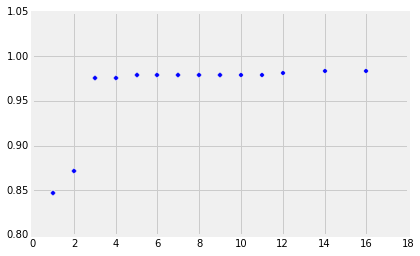

In [30]:
# Plot the data for each sector model
%matplotlib inline
'Cyclical Consumer Goods & Services',
'Telecommunications Services',
'Industrials',
'Energy',
'None Found',
'Utilities',
'Financials',
'Healthcare',
'Basic Materials',
'Technology',
'Non-Cyclical Consumer Goods & Services'

sector = 'Financials'

plt.scatter(x = num_feat_dict[sector], y = accuracy_dict[sector])


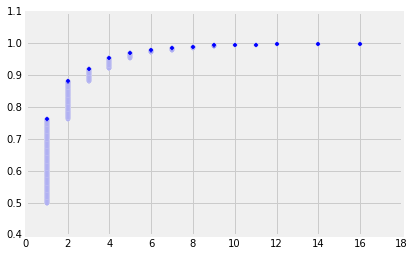

In [31]:
%matplotlib inline
plt.scatter(x = num_feat_dict[sector], y = var_limit_dict[sector])

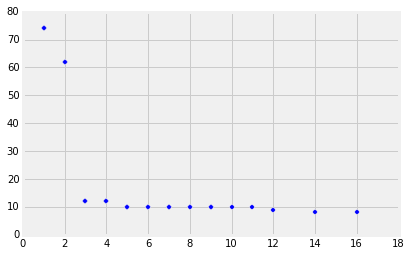

In [32]:
%matplotlib inline
plt.scatter(x = num_feat_dict[sector], y = false_pred_dict[sector])

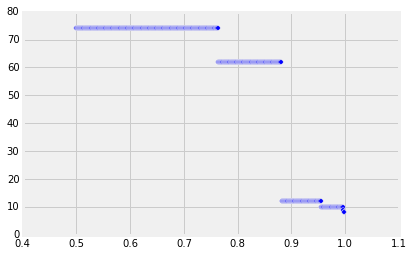

In [33]:
%matplotlib inline
plt.scatter(x = var_limit_dict[sector], y = false_pred_dict[sector])

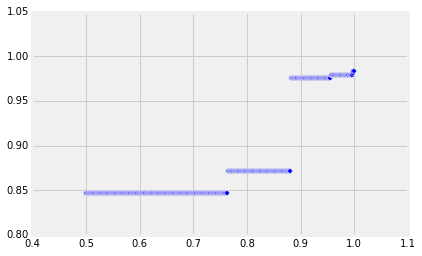

In [34]:
%matplotlib inline
plt.scatter(x = var_limit_dict[sector], y = accuracy_dict[sector])

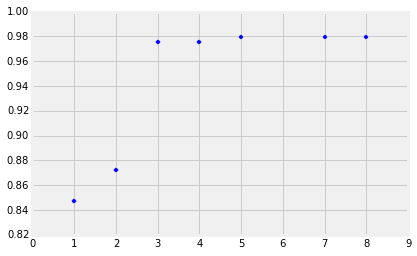

In [27]:
%matplotlib inline
plt.scatter(x = num_feat_dict[sector], y = accuracy_dict[sector])

In [ ]:
#----------------------- test the models ---------------------#

# Read in the test data and then center and scale it

x_test = pd.read_csv('https://raw.githubusercontent.com/wbconnelly/Bill_Data_Sci/master/project%20draft/x_test.csv')
y_test = pd.read_csv('https://raw.githubusercontent.com/wbconnelly/Bill_Data_Sci/master/project%20draft/y_test.csv')

x_test = scaler.fit_transform(x_test[feature_cols])
x_test = pd.DataFrame(x_test, columns = feature_cols)


In [ ]:
# Create a for-loop that uses ensembling to test make predictions on the testing data.

pred_list = []
for sector in sector_list:
    try:
        x_cols = feature_lists[sector]
        y = y_test[sector]

# Use ensembling data with 100 iterations
        for i in range(1,10):
            y_pred = model_list[sector].predict(x_test[x_cols])
            pred_list.append(np.array(y_pred))
            y_pred = np.round(np.mean(pred_list, axis = 0)).astype(int)
        print sector, '---',metrics.accuracy_score(y, y_pred), "number of features ", len(x_cols)
        confusion = metrics.confusion_matrix(y, y_pred)
        TP = confusion[1][1]
        TN = confusion[0][0]
        FP = confusion[0][1]
        FN = confusion[1][0]
        print 'True Positives:', TP
        print 'True Negatives:', TN
        print 'False Positives:', FP
        print 'False Negatives:', FN
    except:
        pass